# Vehicle CO2 Emission Analysis and Prediction
### Introduction
The content of this project is similar to my previous job, which requires me to find the relationships between vehicle information (or other environmental parameters) and the gas emissions. The models of Classification and Clustering are very powerful and useful tools for environmental data analysis. 
In this project:
 * From the components of a vehicle, estimate the CO2 Emissions with K-NearestNeighbor(KNN) method, other than detecting the fuel_combustion information (which directly contributes to CO2 Emissions), it would help customers to choose environmental-friendly vehicles quickly.
 * Analysis the relationship between fuel_combustion data and CO2 Emission, build regression model for prediction.
 * Optimize the prediction of CO2 Emissions by comparison and the application of Random Forest model and XGBoost model.

# Vehicle data Analysis

* download the data set at the following link:

* [**Dataset Download Link**](https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv)

See below for a detailed description of the dataset:

- **MODELYEAR	:** Year of the vehicle model
- **MAKE:** 
- **MODEL:** 
- **VEHICLECLASS:** 
- **ENGINESIZE:** 
- **CYLINDERS:** 
- **TRANSMISSION:** 
- **FUELTYPE:** 
- **FUELCONSUMPTION_CITY:** 
- **FUELCONSUMPTION_HWY:**
- **FUELCONSUMPTION_COMB:**
- **FUELCONSUMPTION_COMB_MPG:**    
- **CO2EMISSIONS:**
    
**The primary goal is to understand what factors are best at predicting whether the features of vehicle related to its CO2 emission, and offer suggestions to operationalize those insights to help with the environmental problems


In [173]:
# import libraries
import wget
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() # inline plots with seaborn style
import scipy
from scipy import stats
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.preprocessing import KBinsDiscretizer,label_binarize
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier,AdaBoostClassifier
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.ensemble import AdaBoostRegressor,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.linear_model import SGDClassifier,SGDRegressor
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.tree import DecisionTreeClassifier,DecisionTreeRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier, XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import r2_score
from sklearn.metrics import roc_auc_score,roc_curve, auc
from sklearn.metrics import make_scorer,accuracy_score,f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
from datetime import timedelta
import warnings
warnings.filterwarnings("ignore")

### Prepare the data

In [2]:
# In practice, researchers often collect environmental data by their own, and the data belong to whom applu the fundings (academy or company)
# Here I use an online course source of vehicle CO2 emission data as the example of analysis:
url ='https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/FuelConsumptionCo2.csv'
file = wget.download(url)

100% [..............................................................................] 72629 / 72629

In [3]:
# check the data intergrity and validation (see if it includes errors, or unformated values, etc.)
df = pd.read_csv(file)
df.index.name = 'id'
df.head()

,MODELYEAR,MAKE,MODEL,VEHICLECLASS,ENGINESIZE,CYLINDERS,TRANSMISSION,FUELTYPE,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
id,,,,,,,,,,,,,
0,2014,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,2014,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,2014,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,2014,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,2014,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [1]:
# # check how many distinct items in each category
# for c in df.columns:
#     print("---- %s ---" % c)
#     print(df[c].value_counts())

In [5]:
# exame if there is any missing data
print(df.info())
print("-"*80)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067 entries, 0 to 1066
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   MODELYEAR                 1067 non-null   int64  
 1   MAKE                      1067 non-null   object 
 2   MODEL                     1067 non-null   object 
 3   VEHICLECLASS              1067 non-null   object 
 4   ENGINESIZE                1067 non-null   float64
 5   CYLINDERS                 1067 non-null   int64  
 6   TRANSMISSION              1067 non-null   object 
 7   FUELTYPE                  1067 non-null   object 
 8   FUELCONSUMPTION_CITY      1067 non-null   float64
 9   FUELCONSUMPTION_HWY       1067 non-null   float64
 10  FUELCONSUMPTION_COMB      1067 non-null   float64
 11  FUELCONSUMPTION_COMB_MPG  1067 non-null   int64  
 12  CO2EMISSIONS              1067 non-null   int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 108.5+ KB
None

* 'MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION' and 'FUELTYPE' are categorical data, while the others are numeric data.

In [6]:
# also check for the duplicates
number_of_duplicates = df.duplicated().sum()
number_of_rows = df.shape[0]
print("{}% of the observations are duplicates.".format(round(number_of_duplicates/number_of_rows*100,1)))

0.0% of the observations are duplicates.


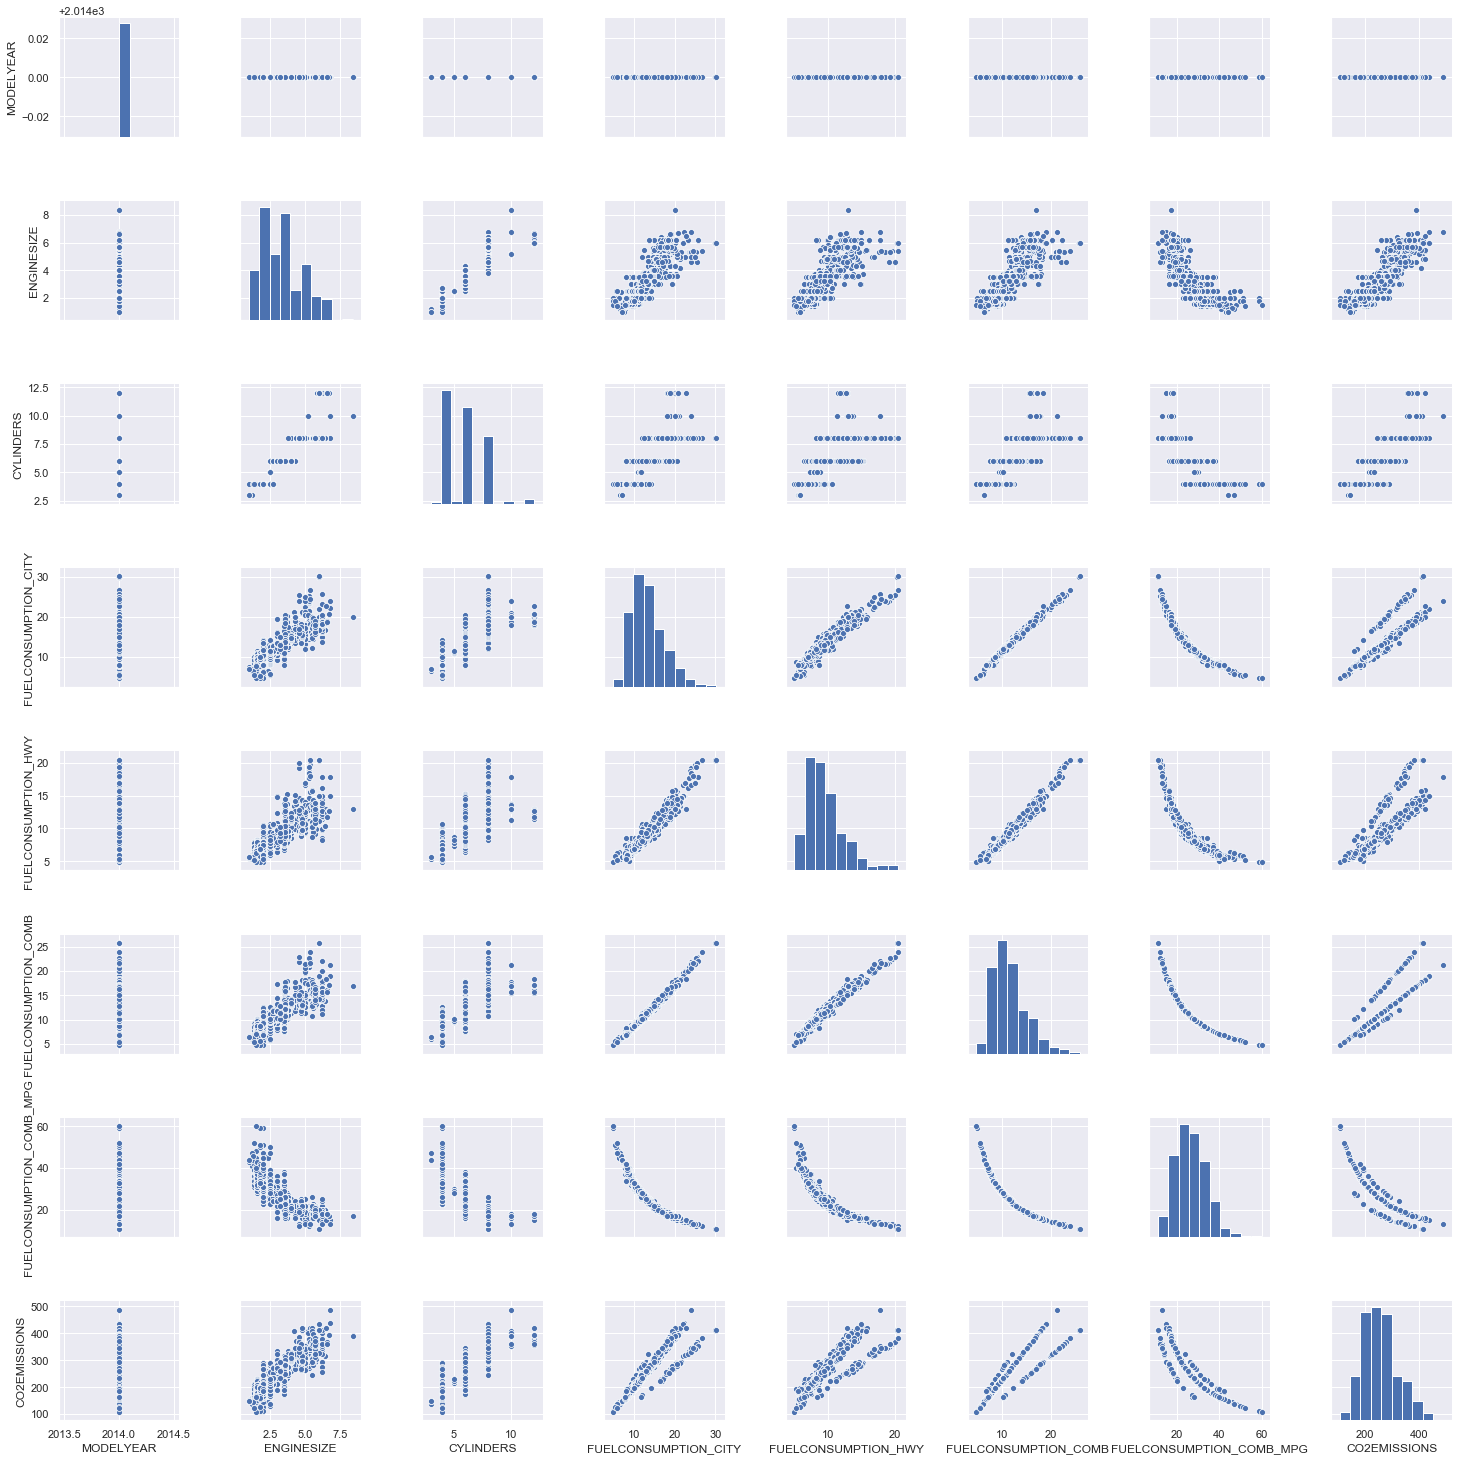

In [7]:
# take a first look at the possible relationships between each feature
sns.pairplot(df)

### A first impression of each feature:
* All modelyear are 2014.
* trends in each row have very similar regress curves, except for the FUELCONSUMPTION_COMBO_MPG column.
* The EngineSize and Cylinders both seemed to closely relate to CO2 Emission, the higher their values, the more CO2 emissions.
* Cylinders vs. CO2 emission have a trend correlates to the sizes of Cylinder, but it doesn't look like linear relation but more like a classification. The reason why this trends is obviouse may be due to the clear order of Cylinder size.
* It means that the other attributes could have likely trends if their categories in a well-order.
* The Engine Size vs. CO2 emission plot is seemly a linear relation.

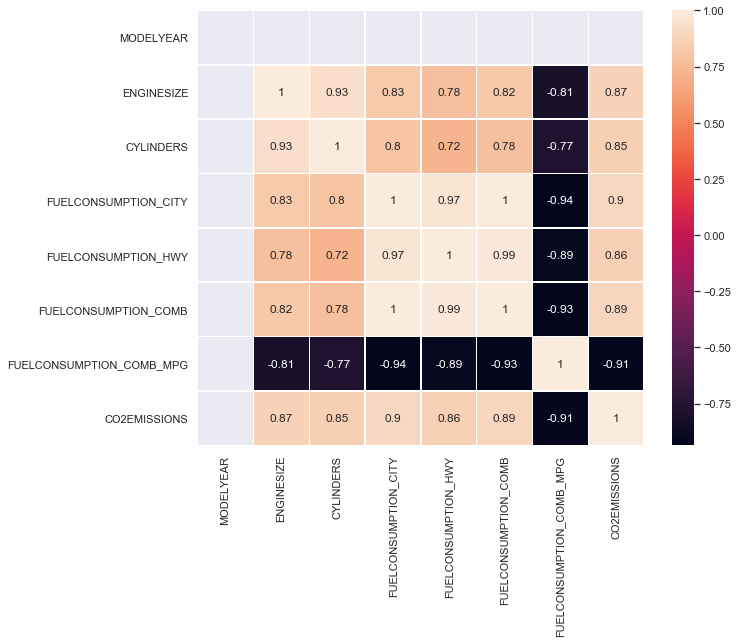

In [8]:
# Use correMatrix to find the relativity of these data
corrMatrix = df.corr()
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.heatmap(corrMatrix, annot=True,linewidths=.5,annot_kws={"size": 12})

* FUELCONSUMPTION_COMB_MPG has negative relationships with other features and the target: CO2EMISSIONS

In [9]:
df.describe()

,MODELYEAR,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
count,1067.0,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000,1067.000000
mean,2014.0,3.346298,5.794752,13.296532,9.474602,11.580881,26.441425,256.228679
std,0.0,1.415895,1.797447,4.101253,2.794510,3.485595,7.468702,63.372304
min,2014.0,1.000000,3.000000,4.600000,4.900000,4.700000,11.000000,108.000000
25%,2014.0,2.000000,4.000000,10.250000,7.500000,9.000000,21.000000,207.000000
50%,2014.0,3.400000,6.000000,12.600000,8.800000,10.900000,26.000000,251.000000
75%,2014.0,4.300000,8.000000,15.550000,10.850000,13.350000,31.000000,294.000000
max,2014.0,8.400000,12.000000,30.200000,20.500000,25.800000,60.000000,488.000000


In [10]:
df.columns

Index(['MODELYEAR', 'MAKE', 'MODEL', 'VEHICLECLASS', 'ENGINESIZE', 'CYLINDERS',
       'TRANSMISSION', 'FUELTYPE', 'FUELCONSUMPTION_CITY',
       'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB',
       'FUELCONSUMPTION_COMB_MPG', 'CO2EMISSIONS'],
      dtype='object')

In [11]:
categorical = ['MAKE', 'MODEL', 'VEHICLECLASS', 'TRANSMISSION','FUELTYPE']
# Since ModelYear are the same in all rows, this feature could be ignore
numeric = ['ENGINESIZE', 'CYLINDERS', 'FUELCONSUMPTION_CITY', 
           'FUELCONSUMPTION_HWY', 'FUELCONSUMPTION_COMB', 'FUELCONSUMPTION_COMB_MPG']
target = ['CO2EMISSIONS']
categorical_df = df[categorical]
numeric_df = df[numeric]
target_df = df[target]

In [12]:
categorical_df.head()

,MAKE,MODEL,VEHICLECLASS,TRANSMISSION,FUELTYPE
id,,,,,
0,ACURA,ILX,COMPACT,AS5,Z
1,ACURA,ILX,COMPACT,M6,Z
2,ACURA,ILX HYBRID,COMPACT,AV7,Z
3,ACURA,MDX 4WD,SUV - SMALL,AS6,Z
4,ACURA,RDX AWD,SUV - SMALL,AS6,Z


In [13]:
def transform(df_1,df_2):
    Encoder = LabelEncoder()
    for i in df_1:
        transform = Encoder.fit(df_2[i])
        df_2[i] = transform.transform(df_2[i])
transform(categorical,categorical_df)

In [14]:
categorical_df.head()

,MAKE,MODEL,VEHICLECLASS,TRANSMISSION,FUELTYPE
id,,,,,
0,0,329,0,10,3
1,0,329,0,20,3
2,0,330,0,17,3
3,0,389,11,11,3
4,0,483,11,11,3


In [15]:
def find_abnormal(df):
    f = plt.figure(figsize=(15,10))
    for i, column in enumerate(df.columns):
        ax = f.add_subplot(3,3,i+1)
        ax = sns.distplot(df[column])
        ax.set_title("feature of {}".format(i+1),fontsize=15)
    plt.subplots_adjust(wspace= 0.5, hspace = 0.5)

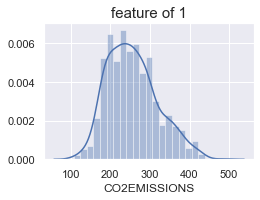

In [16]:
find_abnormal(target_df)

* No Abnormal values

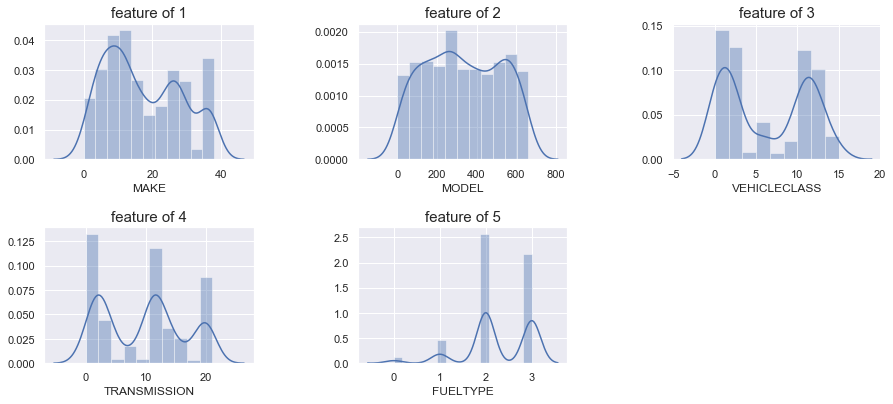

In [17]:
find_abnormal(categorical_df)

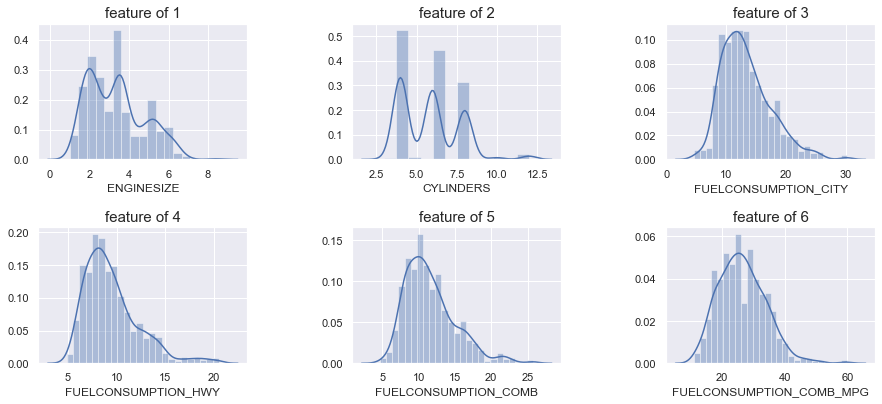

In [18]:
find_abnormal(numeric_df)

In [19]:
def scaler(dataframe):
    scaler = StandardScaler()
    standardized = scaler.fit_transform(dataframe)
    new_df = pd.DataFrame(standardized,columns = dataframe.columns)
    return new_df

In [20]:
scaler(categorical_df)

,MAKE,MODEL,VEHICLECLASS,TRANSMISSION,FUELTYPE
0,-1.575452,-0.010685,-1.244334,0.049460,1.011148
1,-1.575452,-0.010685,-1.244334,1.548707,1.011148
2,-1.575452,-0.005382,-1.244334,1.098933,1.011148
3,-1.575452,0.307489,0.915493,0.199384,1.011148
4,-1.575452,0.805962,0.915493,0.199384,1.011148
...,...,...,...,...,...
1062,1.900538,1.553671,0.915493,0.199384,-0.373826
1063,1.900538,1.553671,0.915493,0.199384,-0.373826
1064,1.900538,1.558974,0.915493,0.199384,-0.373826
1065,1.900538,1.558974,0.915493,0.199384,-0.373826


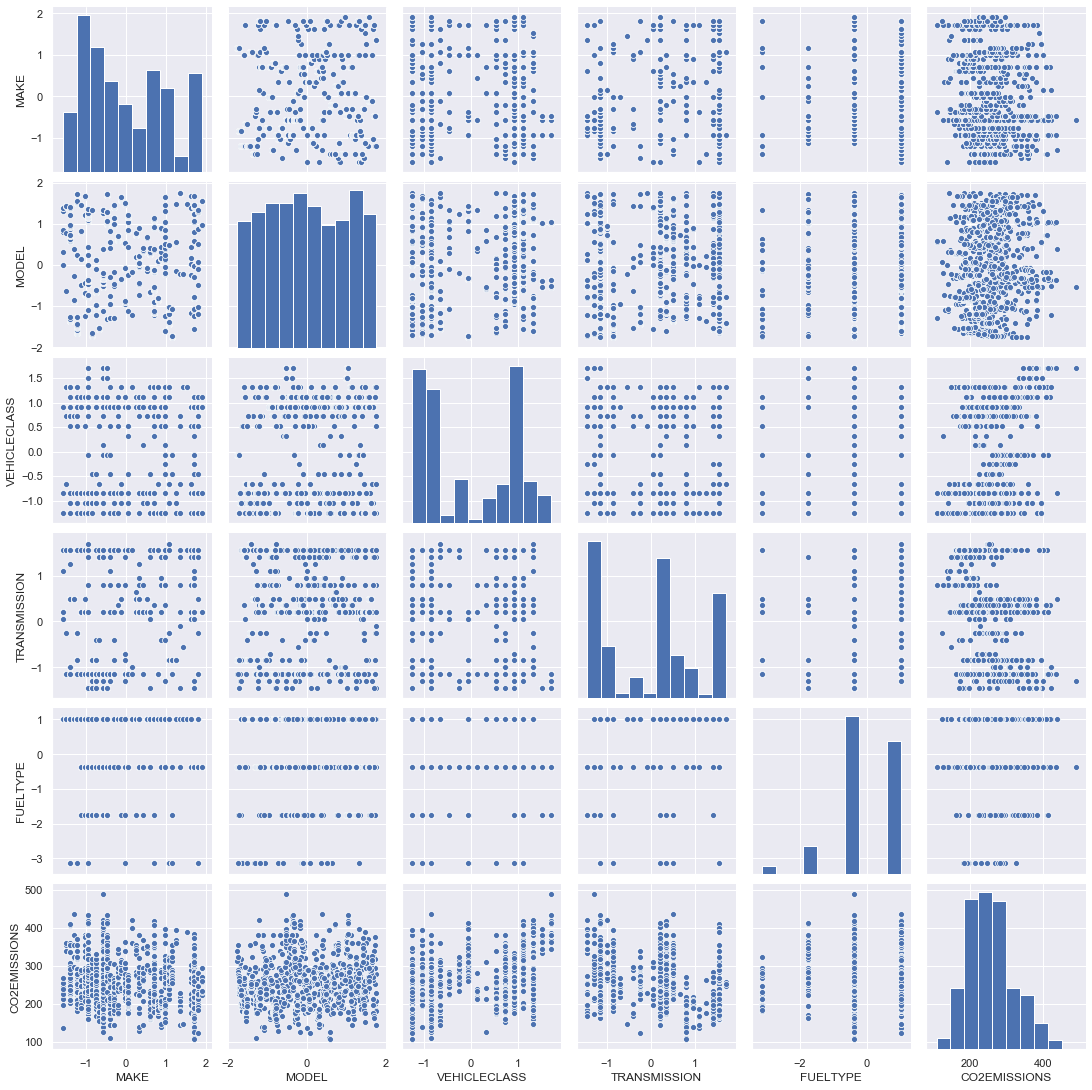

In [21]:
sns.pairplot(pd.concat([scaler(categorical_df),target_df], axis=1))

## Regression

In [22]:
# the target is should not be scaler
standardized_df = pd.concat([scaler(categorical_df),scaler(numeric_df),target_df], axis=1)
standardized_df.head()

,MAKE,MODEL,VEHICLECLASS,TRANSMISSION,FUELTYPE,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,-1.575452,-0.010685,-1.244334,0.049460,1.011148,-0.951292,-0.998969,-0.828558,-0.993341,-0.884304,0.878553,196
1,-1.575452,-0.010685,-1.244334,1.548707,1.011148,-0.668653,-0.998969,-0.511433,-0.635329,-0.568571,0.342734,221
2,-1.575452,-0.005382,-1.244334,1.098933,1.011148,-1.304591,-0.998969,-1.779932,-1.315552,-1.630581,2.887876,136
3,-1.575452,0.307489,0.915493,0.199384,1.011148,0.108606,0.114242,-0.145519,-0.134112,-0.138027,-0.193086,255
4,-1.575452,0.805962,0.915493,0.199384,1.011148,0.108606,0.114242,-0.291885,-0.277317,-0.281542,0.074824,244


In [23]:
X_train, X_test, y_train, y_test = train_test_split(standardized_df[standardized_df.columns.difference(['CO2EMISSIONS'])], 
                                                    standardized_df['CO2EMISSIONS'], 
                                                    test_size=0.2, random_state=2)

In [24]:
print(X_train.shape,X_test.shape)
print('-'*20)
print(y_train.shape,y_test.shape)

(853, 11) (214, 11)
--------------------
(853,) (214,)


## Model Selection

In [119]:
Model = []
RMSE = []
MAE = []
R_2 = []
cv = KFold(8, random_state = 1) # 8 KFold should be enough for avoding overfitting

#Creating a Function to append the cross validation scores of the algorithms
def input_scores(name, model, x, y):
    Model.append(name)
    RMSE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, scoring='neg_mean_squared_error').mean()))
    MAE.append(np.sqrt((-1) * cross_val_score(model, x, y, cv=cv, scoring='neg_mean_absolute_error').mean()))
    R_2.append(cross_val_score(model, x, y, cv=cv, scoring='r2').mean())

In [120]:
names = ['Linear Regression', 'SGD Regressor', 'Ridge Regression', 'Lasso Regression', 
         'K Neighbors Regressor', 'Decision Tree Regressor', 'Extra Trees Regressor',
         'Random Forest Regressor', 'Gradient Boosting Regressor', 'Adaboost Regressor']
models = [LinearRegression(), SGDRegressor(), Ridge(), Lasso(), KNeighborsRegressor(), 
          DecisionTreeRegressor(), ExtraTreesRegressor(), RandomForestRegressor(), 
          GradientBoostingRegressor(), AdaBoostRegressor()]

In [121]:
#Running all algorithms
for name, model in zip(names, models):
    input_scores(name, model, X_train, y_train)

In [122]:
evaluation = pd.DataFrame({'Model': Model,
                           'RMSE': RMSE,
                           'MAE': MAE,
                           'R Squared': R_2})
print("FOLLOWING ARE THE TRAINING SCORES: ")
evaluation

FOLLOWING ARE THE TRAINING SCORES: 


,Model,RMSE,MAE,R Squared
0,Linear Regression,20.234852,3.032840,0.892730
1,SGD Regressor,20.242634,3.057317,0.892210
2,Ridge Regression,20.233039,3.011359,0.892755
3,Lasso Regression,20.269561,3.038625,0.892335
4,K Neighbors Regressor,13.959540,2.731758,0.948797
5,Decision Tree Regressor,10.056903,-0.000000,0.976568
6,Extra Trees Regressor,5.121951,0.342783,0.993009
7,Random Forest Regressor,7.572404,0.465027,0.984907
8,Gradient Boosting Regressor,4.714869,1.254762,0.993832
9,Adaboost Regressor,14.638657,3.103036,0.941946


* Gradient Boosting Regressor wins with RMSE
* Extra Trees Random Forest

## Models Comparison

In [43]:
# Search for the best parameter 
# for many fits with hyperparameters, randomizedSearch perform much faster than Gridsearch
# I need the model to be as accurate as possible so here use the randomizedSearch
def param_select(model,model_param_grid):
    # Perform random search: grid_mse
    randomized_mse = RandomizedSearchCV(estimator=model, param_distributions=model_param_grid,
                                    n_iter=200, cv=3, scoring='neg_mean_squared_error',verbose=1)
    randomized_mse.fit(X_train, y_train)

    # Print the best parameters and lowest RMSE
    print("Best parameters found: ",randomized_mse.best_params_)
    print("Lowest RMSE found: ", np.sqrt(np.abs(randomized_mse.best_score_)))

### 1.Extra Trees

In [123]:
model_etr = ExtraTreesRegressor()
model_param_grid_etr = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'oob_score': [True,False],
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select(model_etr,model_param_grid_etr)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.0min finished


Best parameters found:  {'oob_score': False, 'n_estimators': 1000, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 10}
Lowest RMSE found:  6.59690998252239


## 2.Gradient Boosting

In [44]:
# Instantiate the regressor
model_gbr = GradientBoostingRegressor()
model_param_grid_gbr = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select(model_gbr,model_param_grid_gbr)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  5.4min finished


Best parameters found:  {'n_estimators': 1000, 'min_samples_split': 6, 'min_samples_leaf': 5, 'max_depth': 2}
Lowest RMSE found:  5.704496680188545


### 3. Random Forest

In [47]:
model_dcr = RandomForestRegressor()
model_param_grid_dcr = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'oob_score': [True,False],
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select(model_dcr,model_param_grid_dcr)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  7.0min finished


Best parameters found:  {'oob_score': False, 'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 9}
Lowest RMSE found:  8.631652411814416


### 4. XGBoosting

In [49]:
model_xgbr = XGBRegressor(silent = True)
model_param_grid_xgbr = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'bootstrap': [True,False],
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select(model_xgbr,model_param_grid_xgbr)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.6min finished


Best parameters found:  {'n_estimators': 1000, 'min_samples_split': 4, 'min_samples_leaf': 10, 'max_depth': 2, 'bootstrap': False}
Lowest RMSE found:  6.13686355076767


### Comparison

In [236]:
Model_name = ['Extra Trees','Gradient Boosting','Random Forest','XGBoosting']
Model_reg = [ExtraTreesRegressor(max_depth=10,n_estimators=1000,min_samples_split=2,
                                   min_samples_leaf=1,random_state=1),
             GradientBoostingRegressor(max_depth=2,n_estimators=1000,min_samples_split=6,
                                   min_samples_leaf=5,random_state=11),
             RandomForestRegressor(max_depth=9,n_estimators=200,min_samples_split=2,
                                   min_samples_leaf=2,random_state=22),
             XGBRegressor(max_depth=3,n_estimators=1000,bootstrap=False,
                          min_samples_split=10,min_samples_leaf=4,silent = True,random_state=33)
             ]
RMSE_score = []
MAE_score = []
R_2_score = []

def compare(X_train,y_train,X_test,y_test):
    for i in range(len(Model_name)):
        Model_reg[i].fit(X_train, y_train)
        y_pred = Model_reg[i].predict(X_test)
        RMSE_score.append(np.sqrt(mean_squared_error(y_test, y_pred)))
        MAE_score.append(mean_absolute_error(y_test, y_pred))
        R_2_score.append(r2_score(y_test, y_pred))
        feature_scores = pd.Series(Model_reg[i].feature_importances_, index=X_train.columns).sort_values(ascending=False)
        
        f = plt.figure(figsize=(25,30))
        ax = f.add_subplot(431)
        ax = sns.barplot(x=feature_scores, y=feature_scores.index)
        ax.set_title("Feature scores of {}".format(Model_name[i]),fontsize=20)
        ax.set_yticklabels(feature_scores.index,fontsize=12)
        ax.set_xlabel("Feature importance score",fontsize=20)
        ax.set_ylabel("Features",fontsize=15)
       
        ax = f.add_subplot(432)
        ax = sns.scatterplot(y_test,y_test,ax=ax,color='red',label='Test')
        ax = sns.lineplot(y_test,y_pred,ax=ax,color='blue',label='Predict')
        ax.set_title('Check for Linearity of {}:\n Actual Vs Predicted value'.format(Model_name[i]),fontsize=20)
        
        ax = f.add_subplot(433)
        ax = sns.distplot((y_test - y_pred),ax=ax,kde_kws={'bw':1.0},color='b')
        ax.axvline((y_test - y_pred).mean(),color='k',linestyle='--')
        ax.set_title('Check for {} \n Residual normality & mean: Residual eror'.format(Model_name[i]),fontsize=20)
        
        plt.show()

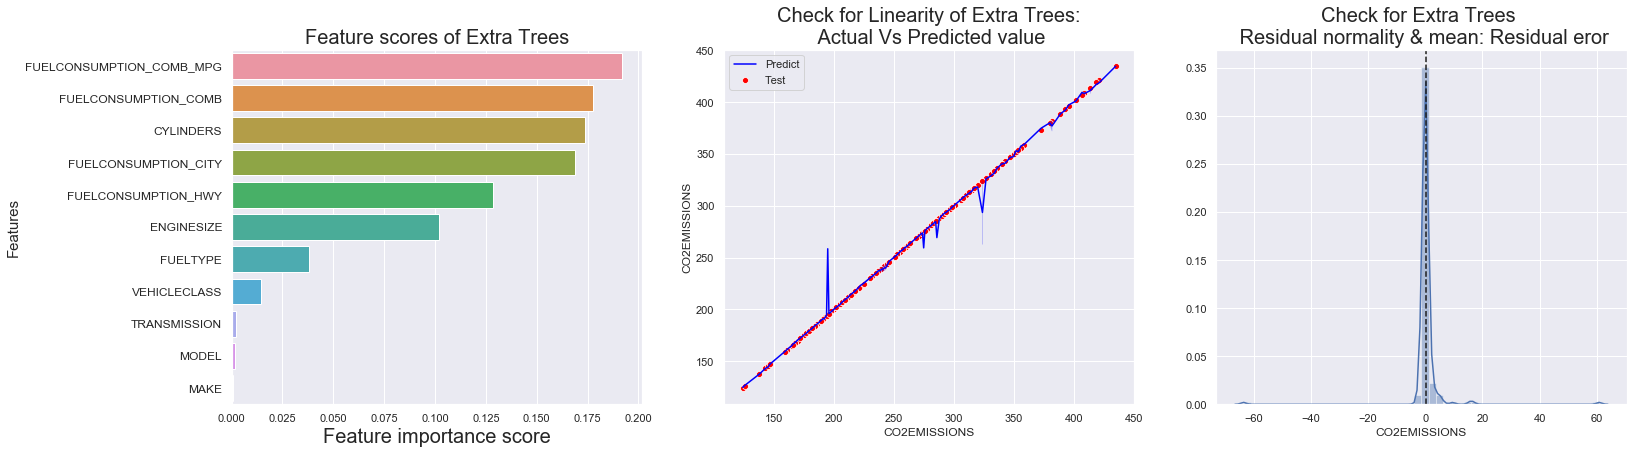

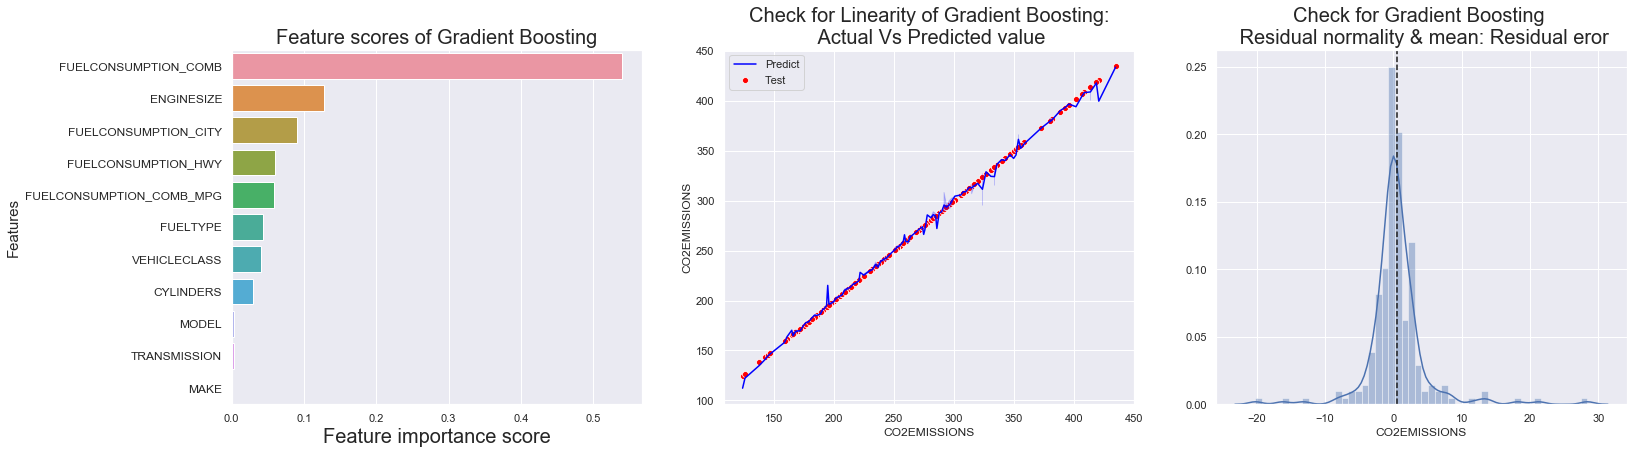

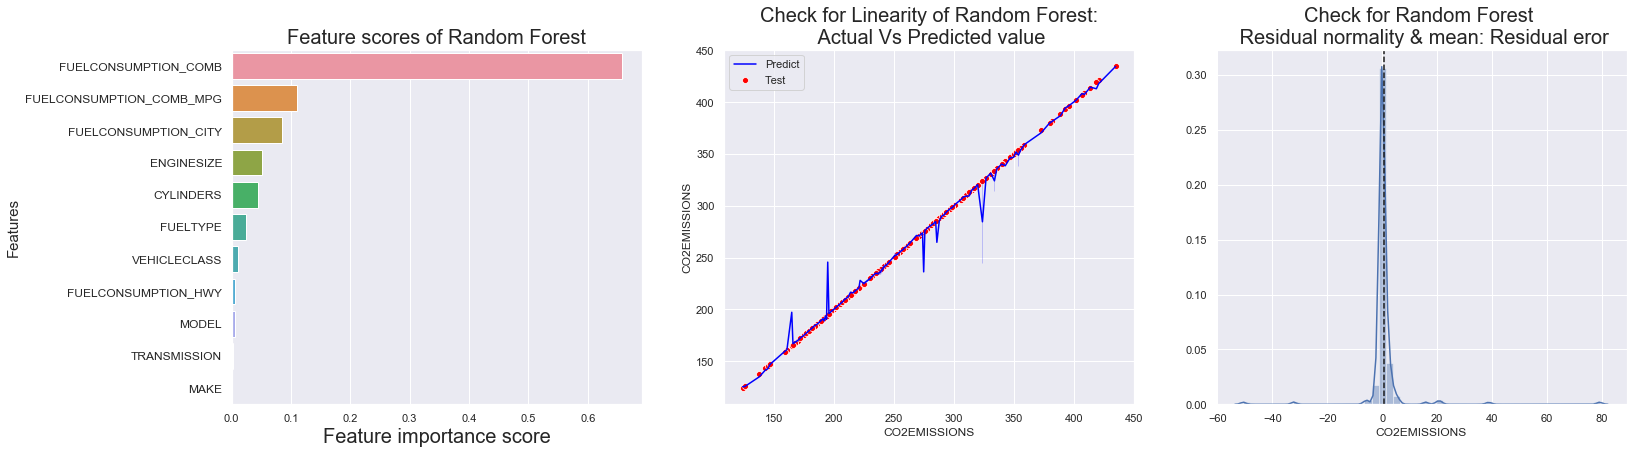

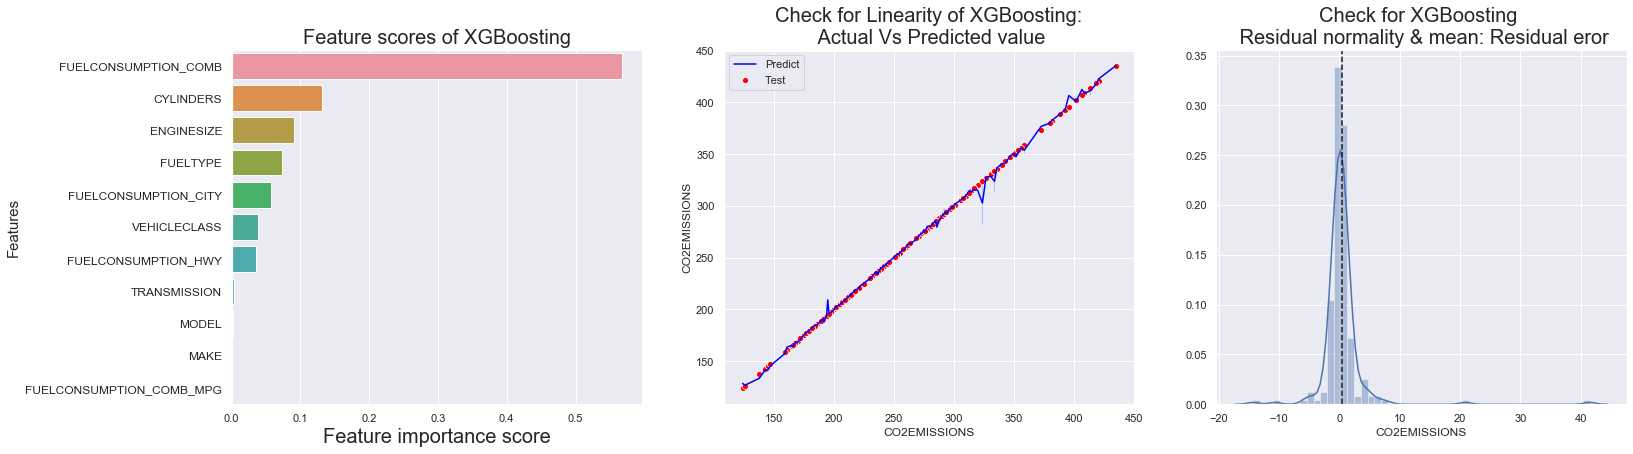

In [237]:
compare(X_train,y_train,X_test,y_test)

Model Validation

In order to validated model we need to check few assumption of linear regression model. The common assumption for Linear Regression model are following

    Linear Relationship: In linear regression the relationship between the dependent and independent variable to be linear. This can be checked by scatter ploting Actual value Vs Predicted value
    The residual error plot should be normally distributed.
    The mean of residual error should be 0 or close to 0 as much as possible
    The linear regression require all variables to be multivariate normal. This assumption can best checked with Q-Q plot.
    Linear regession assumes that there is little or no Multicollinearity in the data. Multicollinearity occurs when the independent variables are too highly correlated with each other. The variance inflation factor VIF* identifies correlation between independent variables and strength of that correlation. VIF=11−R2

, If VIF >1 & VIF <5 moderate correlation, VIF < 5 critical level of multicollinearity.
Homoscedasticity: The data are homoscedastic meaning the residuals are equal across the regression line. We can look at residual Vs fitted value scatter plot. If heteroscedastic plot would exhibit a funnel shape pattern.

In [238]:
Comparison = pd.DataFrame({'Model': Model_name,
                           'RMSE': RMSE_score,
                           'MAE': MAE_score,
                           'R Squared': R_2_score})
print("FOLLOWING ARE THE SCORES: ")
Comparison

FOLLOWING ARE THE SCORES: 


,Model,RMSE,MAE,R Squared
0,Extra Trees,6.335007,1.278283,0.991333
1,Gradient Boosting,4.461795,2.434106,0.995701
2,Random Forest,7.745957,1.892659,0.987043
3,XGBoosting,3.798974,1.492364,0.996883


## Classification

In [132]:
numeric_df_2 = numeric_df.copy()
target_df_2 = target_df.copy()

In [133]:
def binsdiscretizer(df,n):
    enc = KBinsDiscretizer(n_bins=n, encode='ordinal', strategy='kmeans')
    df_value = df.values
    df_value = enc.fit_transform(df_value)
    return pd.DataFrame(df_value,columns = df.columns)
binsdiscretizer(numeric_df_2,10).head()

,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG
0,1.0,1.0,1.0,0.0,1.0,4.0
1,1.0,1.0,2.0,1.0,2.0,3.0
2,0.0,1.0,0.0,0.0,0.0,7.0
3,3.0,3.0,3.0,2.0,3.0,2.0
4,3.0,3.0,2.0,2.0,2.0,3.0


In [137]:
discretizer_df = pd.concat([categorical_df, binsdiscretizer(numeric_df_2,10),
                            binsdiscretizer(target_df_2,10)], axis=1)
discretizer_df.head()

,MAKE,MODEL,VEHICLECLASS,TRANSMISSION,FUELTYPE,ENGINESIZE,CYLINDERS,FUELCONSUMPTION_CITY,FUELCONSUMPTION_HWY,FUELCONSUMPTION_COMB,FUELCONSUMPTION_COMB_MPG,CO2EMISSIONS
0,0,329,0,10,3,1.0,1.0,1.0,0.0,1.0,4.0,2.0
1,0,329,0,20,3,1.0,1.0,2.0,1.0,2.0,3.0,2.0
2,0,330,0,17,3,0.0,1.0,0.0,0.0,0.0,7.0,0.0
3,0,389,11,11,3,3.0,3.0,3.0,2.0,3.0,2.0,3.0
4,0,483,11,11,3,3.0,3.0,2.0,2.0,2.0,3.0,3.0


In [56]:
Xc_train, Xc_test, yc_train, yc_test = train_test_split(discretizer_df[discretizer_df.columns.difference(['CO2EMISSIONS'])], 
                                                    discretizer_df['CO2EMISSIONS'], 
                                                    test_size=0.2, random_state=52)

In [57]:
print(Xc_train.shape,Xc_test.shape)
print('-'*20)
print(yc_train.shape,yc_test.shape)

(853, 11) (214, 11)
--------------------
(853,) (214,)


In [58]:
Model_2 = []
Accuracy = []
F_1_Macro = []
F_1_Micro = []
Precision_Macro = []
Precision_Micro = []

cv = KFold(8, random_state = 1) # 8 KFold should be enough for avoding overfitting

#Creating a Function to append the cross validation scores of the algorithms
def classifier_scores(name, model, x, y):
    Model_2.append(name)
    Accuracy.append(cross_val_score(model, x, y, cv=cv, scoring='accuracy').mean())
    F_1_Macro.append(cross_val_score(model, x, y, cv=cv, scoring='f1_macro').mean())
    F_1_Micro.append(cross_val_score(model, x, y, cv=cv, scoring='f1_micro').mean())
    Precision_Macro.append(cross_val_score(model, x, y, cv=cv, scoring='precision_macro').mean())
    Precision_Micro.append(cross_val_score(model, x, y, cv=cv, scoring='precision_micro').mean())
    

In [59]:
names_2 = ['Support Vector Machine', 'ExtraTrees Classifier', 'Decision Tree Classifier',  
         'RandomForest Classifier', 'Gradient Boosting Classifier', 
         'Adaboost Classifier','K Neighbors Classifier','SGD Classifier']
models_2 = [SVC(), ExtraTreesClassifier(), DecisionTreeClassifier(),
          RandomForestClassifier(), GradientBoostingClassifier(),
          AdaBoostClassifier(), KNeighborsClassifier(), SGDClassifier()]

In [60]:
#Running all algorithms
for name, model in zip(names_2, models_2):
    classifier_scores(name, model, Xc_train, yc_train)

In [61]:
analysis = pd.DataFrame({'Model': Model_2,
                        'Accuracy': Accuracy,
                        'F_1_Macro': F_1_Macro,
                        'F_1_Micro': F_1_Micro,
                        'Precision_Macro': Precision_Macro,
                        'Precision_Micro': Precision_Micro})
print("FOLLOWING ARE THE TRAINING SCORES: ")
analysis

FOLLOWING ARE THE TRAINING SCORES: 


,Model,Accuracy,F_1_Macro,F_1_Micro,Precision_Macro,Precision_Micro
0,Support Vector Machine,0.241503,0.074374,0.241503,0.054258,0.241503
1,ExtraTrees Classifier,0.847635,0.884836,0.847635,0.899657,0.847657
2,Decision Tree Classifier,0.818396,0.829980,0.813756,0.840369,0.819609
3,RandomForest Classifier,0.857047,0.866285,0.850026,0.869057,0.853509
4,Gradient Boosting Classifier,0.844207,0.863026,0.838322,0.871841,0.845376
5,Adaboost Classifier,0.492495,0.265010,0.492495,0.228275,0.492495
6,K Neighbors Classifier,0.437291,0.412536,0.437291,0.481955,0.437291
7,SGD Classifier,0.274268,0.111719,0.245151,0.176387,0.246352


In [64]:
def param_select_classifier(model,model_param_grid):
    # Perform random search: grid_mse
    randomized_f1 = RandomizedSearchCV(estimator=model, param_distributions=model_param_grid,
                                    n_iter=200, cv=3, scoring='f1_micro',verbose=1)
    randomized_f1.fit(Xc_train, yc_train)

    # Print the best parameters and lowest RMSE
    print("Best parameters found: ",randomized_f1.best_params_)
    print("F_1 found: ", randomized_f1.best_score_)

In [65]:
model_etc = ExtraTreesClassifier()
model_param_grid_etc = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'oob_score': [True,False],
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select_classifier(model_etc,model_param_grid_etc)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  2.2min finished


Best parameters found:  {'oob_score': False, 'n_estimators': 800, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_depth': 10}
F_1 found:  0.8581747796721851


In [66]:
model_rfc = RandomForestClassifier()
model_param_grid_rfc = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'oob_score': [True,False],
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select_classifier(model_rfc,model_param_grid_rfc)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed:  6.0min finished


Best parameters found:  {'oob_score': False, 'n_estimators': 200, 'min_samples_split': 3, 'min_samples_leaf': 1, 'max_depth': 8}
F_1 found:  0.8441026274606704


In [67]:
model_gbc = GradientBoostingClassifier()
model_param_grid_gbc = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select_classifier(model_gbc,model_param_grid_gbc)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 24.8min finished


Best parameters found:  {'n_estimators': 400, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_depth': 9}
F_1 found:  0.8476072811135821


In [68]:
model_xgbc = XGBClassifier(silent = True)
model_param_grid_xgbc = {'n_estimators': range(0,1200,200),
                        'max_depth': range(2,12),
                        'min_samples_split': range(1,11),
                        'min_samples_leaf': range(1,11)}
param_select_classifier(model_xgbc,model_param_grid_xgbc)

Fitting 3 folds for each of 200 candidates, totalling 600 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 600 out of 600 | elapsed: 14.2min finished


Best parameters found:  {'n_estimators': 200, 'min_samples_split': 8, 'min_samples_leaf': 2, 'max_depth': 2}
F_1 found:  0.8347047195453423


In [234]:
Model_clf_name = ['Extra Trees','Random Forest','Gradient Boosting','XGBoosting']
Model_clf = [ExtraTreesClassifier(oob_score=False, n_estimators=800, 
                                 min_samples_split=4, min_samples_leaf=1, 
                                 max_depth=10, random_state=44),
             RandomForestClassifier(oob_score=False, n_estimators=200, 
                                    min_samples_split=3, min_samples_leaf=1, 
                                    max_depth=8,random_state=55),
             GradientBoostingClassifier(n_estimators=400, 
                                    min_samples_split=3, min_samples_leaf=2, 
                                    max_depth=9, random_state=66),
             XGBClassifier(n_estimators=200, 
                                    min_samples_split=8, min_samples_leaf=2, 
                                    max_depth=2, random_state=77)
             ]
Roc_Auc_Macro = []
F1_Macro = []
F1_Micro = []

def compare_clf(X_train,y_train,X_test,y_test):
    for i in range(len(Model_clf_name)):
        Model_clf[i].fit(X_train, y_train)
        y_pred = Model_clf[i].predict_proba(X_test)
        y_one_hot = label_binarize(y_test,np.arange(y_test.size)) # covert to one_hot code for roc_auc
        Roc_Auc_Macro.append(roc_auc_score(y_one_hot, y_pred, average = 'macro',multi_class='ovr'))
        # for multi_class f1 score, the value have to be reformated to 1-D shape
        # because Classification metrics can't handle a mix of multiclass and continuous-multioutput targets
        # reference: https://github.com/kk7nc/Text_Classification/issues/8
        F1_Macro.append(f1_score(y_test, np.argmax(y_pred, axis = 1), average = 'macro'))  
        F1_Micro.append(f1_score(y_test, np.argmax(y_pred, axis = 1), average = 'micro'))
        clf_report = classification_report(y_test,np.argmax(y_pred, axis = 1),output_dict=True)
        feature_scores = pd.Series(Model_clf[i].feature_importances_, index=X_train.columns).sort_values(ascending=False)
        
        f = plt.figure(figsize=(25,30))
        ax = f.add_subplot(431)
        ax = sns.barplot(x=feature_scores, y=feature_scores.index)
        ax.set_title("Feature scores of {}".format(Model_clf_name[i]),fontsize=20)
        ax.set_yticklabels(feature_scores.index,fontsize=12)
        ax.set_xlabel("Feature importance score",fontsize=15)
        ax.set_ylabel("Features",fontsize=15)
       
        ax = f.add_subplot(432)
        ax = sns.scatterplot(y_test,y_test,ax=ax,color='red',label = 'Test')
        ax = sns.lineplot(y_test,np.argmax(y_pred, axis = 1),ax=ax,color='blue',label='Predict')
        ax.set_title('Check for Linearity of {}:\n Actual Vs Predicted value'.format(Model_clf_name[i]),fontsize=20)
        
        ax = f.add_subplot(433)
        ax.set_title('Check for Confusion Matrix \n of {}'.format(Model_clf_name[i]),fontsize=20)
        ax = sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True)

        plt.show()

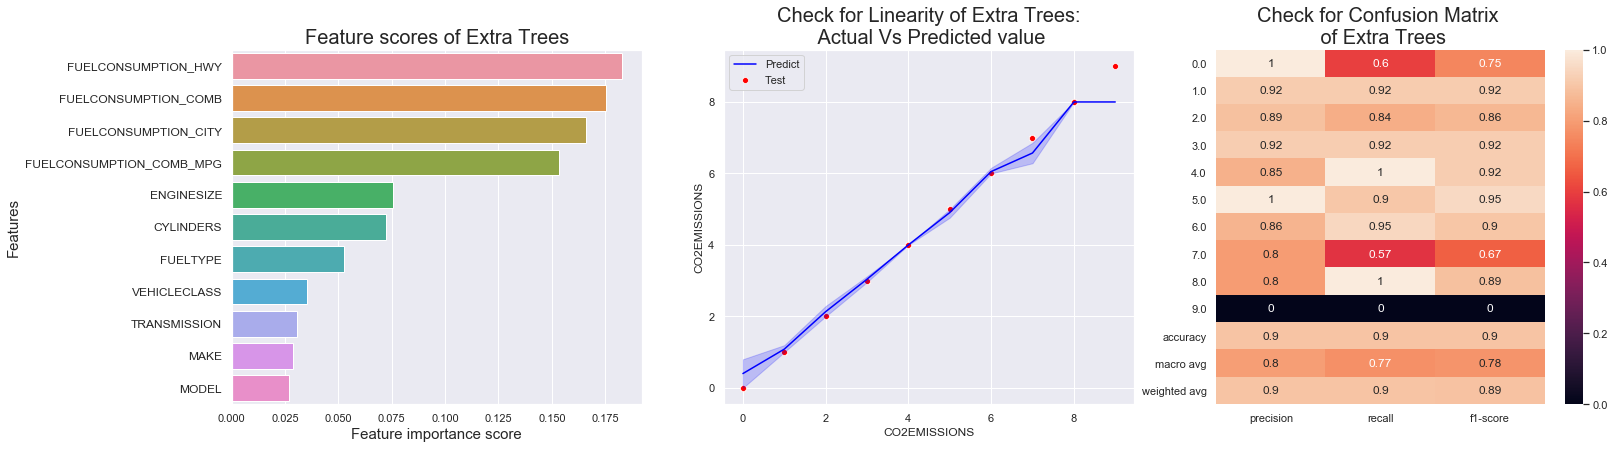

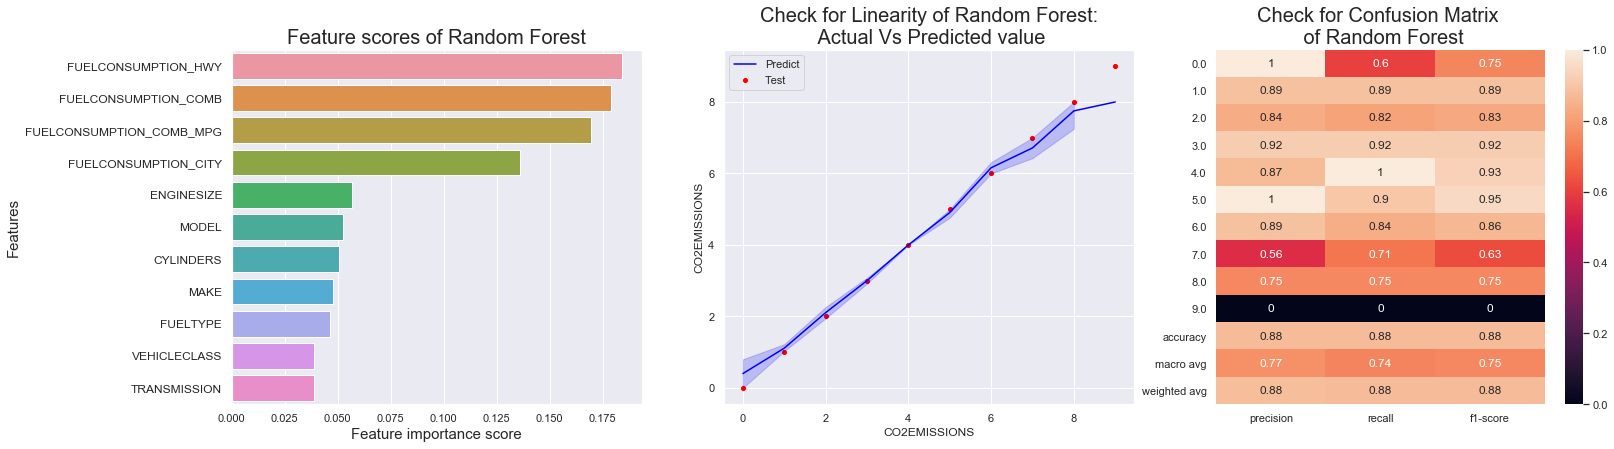

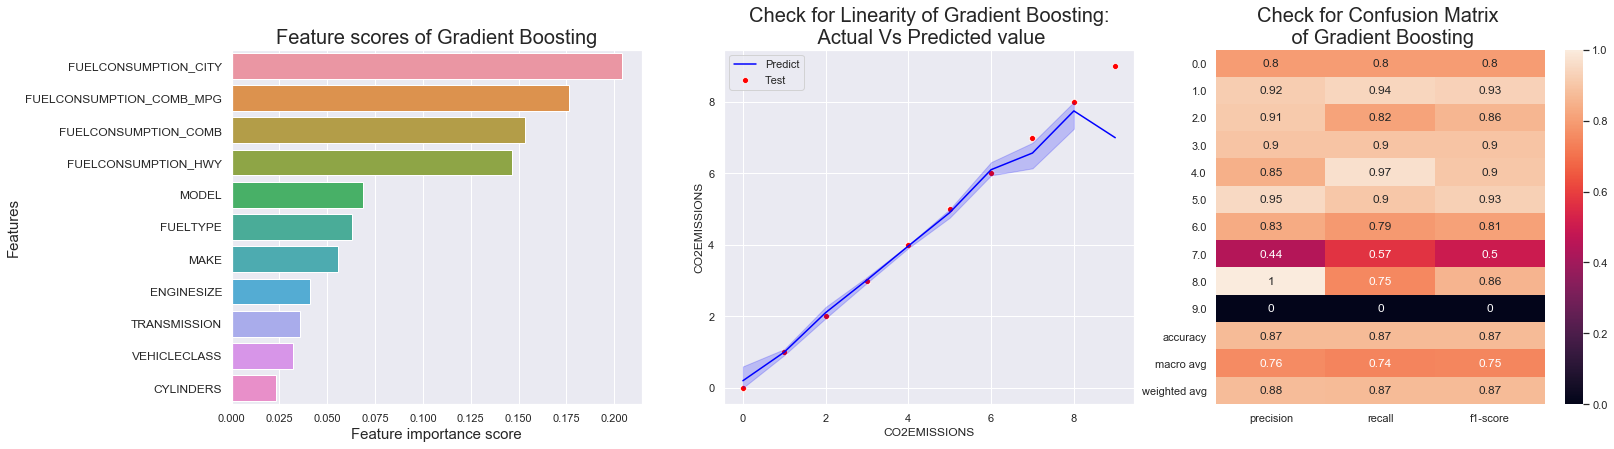

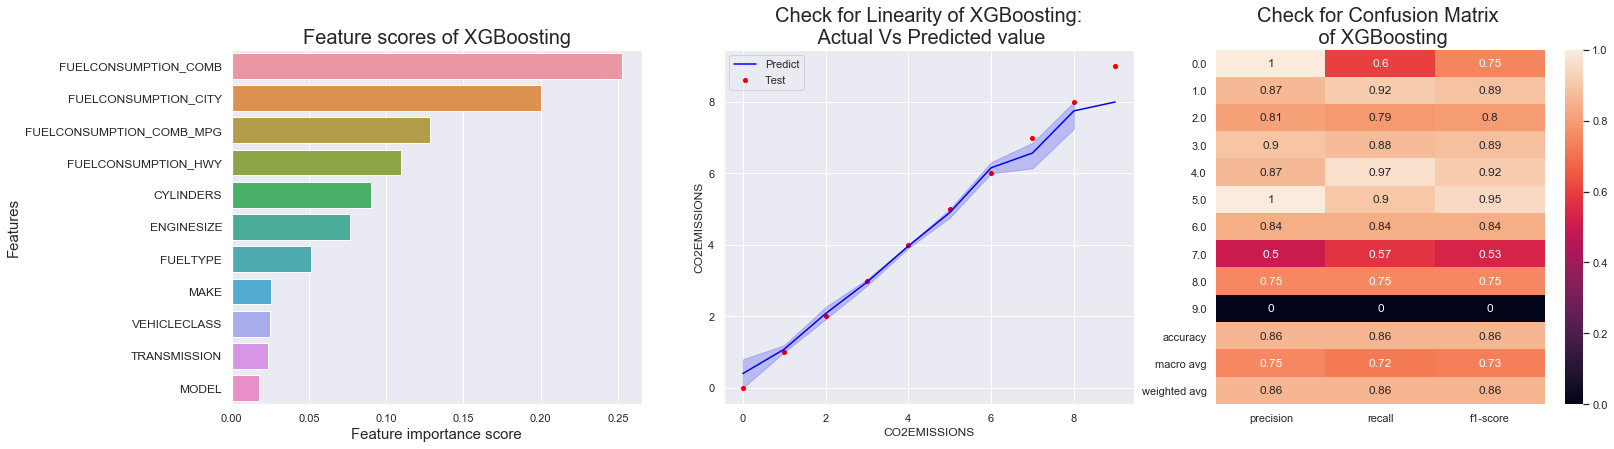

In [235]:
compare_clf(Xc_train,yc_train,Xc_test,yc_test)

In [239]:
Comparison_clf = pd.DataFrame({'Model': Model_clf_name,
                               'Roc_Auc_Macro': Roc_Auc_Macro,
                               'F1_Macro': F1_Macro,
                               'F1_Micro': F1_Micro})
print("FOLLOWING ARE THE SCORES: ")
Comparison_clf

FOLLOWING ARE THE SCORES: 


,Model,Roc_Auc_Macro,F1_Macro,F1_Micro
0,Extra Trees,0.992720,0.777437,0.897196
1,Random Forest,0.991830,0.750529,0.878505
2,Gradient Boosting,0.969706,0.748947,0.873832
3,XGBoosting,0.985835,0.732060,0.859813
